# CNN_mat
*this notebook will implement deep learning on the preprocessed svhn data and train a model that can recognize house number*

In [2]:
from __future__ import print_function
from six.moves import cPickle as pickle
import tensorflow as tf
from sklearn import linear_model as lr
from sklearn.metrics import confusion_matrix, classification_report
import display_center
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<br \>
## Step 1 Load Data From Pickle
<br \>

In [3]:
# unpack the data from files
def unpickle(file_name):
    print("loading %s" %file_name)
    try:
        with open(file_name, "rb") as f:
            data = pickle.load(f)
            print("SUCCESS!")
            return data['X'].astype(np.float32), data['y'].astype(np.float32)
    except Exception as e:
        print("FAILED: ", e)
        

In [4]:
train_X, train_y = unpickle("train.pickle")
print(train_X.shape, train_y.shape)
val_X, val_y = unpickle("validation.pickle")
print(val_X.shape, val_y.shape)
test_X, test_y = unpickle("test.pickle")
print(test_X.shape, test_y.shape)

loading train.pickle
SUCCESS!
(100000, 32, 32) (100000,)
loading validation.pickle
SUCCESS!
(6000, 32, 32) (6000,)
loading test.pickle
SUCCESS!
(26032, 32, 32) (26032,)


*** Display Some Images to Make Sure They're Good ***

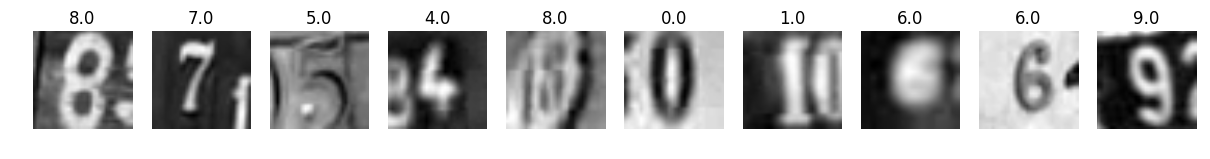

In [5]:
display_center.sample_display(train_X, train_y, plt = plt)

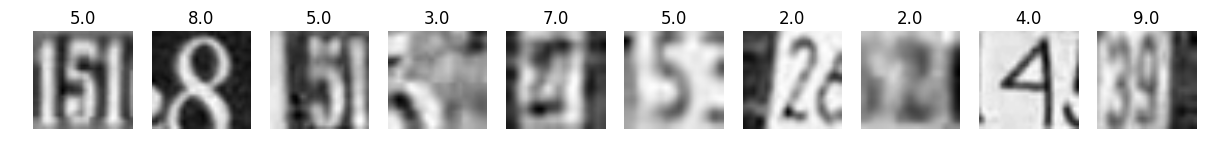

In [6]:
display_center.sample_display(val_X, val_y, plt)

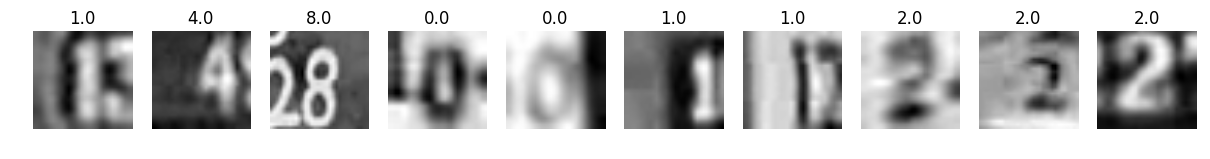

In [7]:
display_center.sample_display(test_X, test_y, plt)

<br \>

<br \>


## Step 2 Build a CNN model
the next cell will build a computational graph for cnn

In [8]:
# before building the graph, reshape the image
imsize = 32
train_X = train_X.reshape([-1, imsize, imsize, 1])
test_X = test_X.reshape([-1, imsize, imsize, 1])
val_X = val_X.reshape([-1, imsize, imsize, 1])
print(train_X.shape)
print(test_X.shape)
print(val_X.shape)

(100000, 32, 32, 1)
(26032, 32, 32, 1)
(6000, 32, 32, 1)


In [9]:
# ohe the y
num_labels = 10
num_channels = 1
def ohe(y):
    y = y.reshape([-1, 1])
    return (np.arange(num_labels) == y).astype(np.float32)
train_y = ohe(train_y)
test_y = ohe(test_y)
val_y = ohe(val_y)

<br \>
### accuracy function definition

In [10]:
def accuracy(pred, y):
    return 100.0 * np.sum(np.argmax(y, axis = 1) == np.argmax(pred, axis = 1))/float(y.shape[0])

<br \>
### the model

def variable_summaries(var, name):
    '''Attach summaries to a Tensor'''
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        


#### model No.1: 71.09

batch_size = 256
patch_size = 5
depth = 32
num_hidden = 128

graph = tf.Graph()

with graph.as_default(): # conv-conv-drop-conv-pool-fc-fc-out
    # Input data
    net_train_X = tf.placeholder(tf.float32, shape = (batch_size, imsize, imsize, num_channels))
    net_train_y = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    net_val_X = tf.constant(val_X)
    net_test_X = tf.constant(test_X)
    
    f1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth]))
    b1 = tf.Variable(tf.zeros([depth]))
    
    fc1_w = tf.Variable(tf.truncated_normal([imsize//2*imsize//2*depth, num_hidden]))
    fc1_b = tf.Variable(tf.constant(1.0, shape = [num_hidden]))
    fc2_w = tf.Variable(tf.truncated_normal([num_hidden, num_labels]))
    fc2_b = tf.Variable(tf.constant(1.0, shape = [num_labels]))
    
    def model(data, drop = False): # conv-drop-conv-conv-pool-fc-fc
        conv = tf.nn.conv2d(data, f1, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b1)
        
        shape = relu.get_shape().as_list()
        reshape = tf.reshape(relu, [shape[0], shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_w) + fc1_b)
        return tf.matmul(hidden, fc2_w) + fc2_b
    
    
    logits = model(net_train_X, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, net_train_y))
    global_step = tf.Variable(0)
    learning_rate = 1e-3
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step = global_step)
    train_pred = tf.nn.softmax(model(net_train_X))
    
    val_pred = tf.nn.softmax(model(net_val_X))
    test_pred = tf.nn.softmax(model(net_test_X))
    
    saver = tf.train.Saver()

### model No.2 90.09%
batch_size = 256
patch_size = 5
depth = [32, 32]
num_hidden = 128

graph = tf.Graph()

with graph.as_default(): # conv-conv-conv-pool-fc-fc-out
    # Input data
    net_train_X = tf.placeholder(tf.float32, shape = (batch_size, imsize, imsize, num_channels))
    net_train_y = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    
    net_val_X = tf.constant(val_X)
    net_test_X = tf.constant(test_X)
    

    f1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth[0]], stddev = 0.01))
    b1 = tf.Variable(tf.zeros([depth[0]]))
    
    f2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth[0], depth[1]], stddev = 0.01))
    b2 = tf.Variable(tf.zeros([depth[1]]))
    
   
    fc1_w = tf.Variable(tf.truncated_normal([imsize//8*imsize//8*32, num_hidden], stddev = 0.3))
    fc1_b = tf.Variable(tf.constant(1.0, shape = [num_hidden]))
    
    fc2_w = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev = 0.3))
    fc2_b = tf.Variable(tf.constant(1.0, shape = [num_labels]))
    
 


    def model(data, drop = False): # conv-conv-pool-drop-fc-fc
    
        conv = tf.nn.conv2d(data, f1, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b1)
        dropped = tf.nn.dropout(relu, .5) if drop else relu
        
        conv = tf.nn.conv2d(dropped, f2, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b2)
        pool = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding = 'SAME')
                 
        ## started to fc
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_w)) + fc1_b
        return tf.matmul(hidden, fc2_w) + fc2_b

    logits = model(net_train_X, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, net_train_y))

    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(1e-2, global_step, 500, .88)

    optimizer = tf.train.AdamOptimizer().minimize(loss)
  
    train_pred = tf.nn.softmax(model(net_train_X))
    val_pred = tf.nn.softmax(model(net_val_X))
    test_pred = tf.nn.softmax(model(net_test_X))
    saver = tf.train.Saver()

##### not used 
batch_size = 256
patch_size = [5, 5, 3]
depth = [32, 64, 128]
num_hidden = 256

graph = tf.Graph()

with graph.as_default(): # conv-conv-conv-pool-fc-fc-out
    # Input data
    net_train_X = tf.placeholder(tf.float32, shape = (batch_size, imsize, imsize, num_channels))
    net_train_y = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    
    net_val_X = tf.constant(val_X)
    net_test_X = tf.constant(test_X)
    
    # Variables
    # f for filter, b for bias
    f1 = tf.Variable(tf.truncated_normal([patch_size[0], patch_size[0], num_channels, depth[0]], stddev = 0.01))
    b1 = tf.Variable(tf.zeros([depth[0]]))
    
    f2 = tf.Variable(tf.truncated_normal([patch_size[1], patch_size[1], depth[0], depth[1]], stddev = 0.01))
    b2 = tf.Variable(tf.zeros([depth[1]]))
    
    f3 = tf.Variable(tf.truncated_normal([patch_size[2], patch_size[2], depth[1], depth[2]], stddev = 0.01))
    b3 = tf.Variable(tf.zeros([depth[2]]))
   
    fc1_w = tf.Variable(tf.truncated_normal([imsize//16*imsize//16*depth[-1], num_hidden], stddev = 0.3))
    fc1_b = tf.Variable(tf.constant(1.0, shape = [num_hidden]))
    
    fc2_w = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev = 0.3))
    fc2_b = tf.Variable(tf.constant(1.0, shape = [num_labels]))
    
 


    def model(data, drop = False): # conv-drop-conv-conv-pool-fc-fc
    
        conv = tf.nn.conv2d(data, f1, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b1)
        dropped = tf.nn.dropout(relu, .5) if drop else relu
        
        conv = tf.nn.conv2d(dropped, f2, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b2)
        
        conv = tf.nn.conv2d(relu, f3, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b3)
        
        pool = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding = 'SAME')
                 
        ## started to fc
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_w)) + fc1_b
        return tf.matmul(hidden, fc2_w) + fc2_b

    logits = model(net_train_X, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, net_train_y))

    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(1e-2, global_step, 500, .88)

    optimizer = tf.train.AdamOptimizer().minimize(loss)
  
    train_pred = tf.nn.softmax(model(net_train_X))
    val_pred = tf.nn.softmax(model(net_val_X))
    test_pred = tf.nn.softmax(model(net_test_X))


#### model 3 94.03%


batch_size = 256
patch_size = [5, 5, 3]
depth = [32, 64, 256]
num_hidden = 128

graph = tf.Graph()

with graph.as_default(): # conv-conv-conv-pool-fc-fc-out
    # Input data
    net_train_X = tf.placeholder(tf.float32, shape = (batch_size, imsize, imsize, num_channels))
    net_train_y = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    
    net_val_X = tf.constant(val_X)
    net_test_X = tf.constant(test_X)
    
    # Variables
    # f for filter, b for bias
    f1 = tf.Variable(tf.truncated_normal([patch_size[0], patch_size[0], num_channels, depth[0]], stddev = 0.01))
    b1 = tf.Variable(tf.zeros([depth[0]]))
    
    f2 = tf.Variable(tf.truncated_normal([patch_size[1], patch_size[1], depth[0], depth[1]], stddev = 0.02))
    b2 = tf.Variable(tf.zeros([depth[1]]))
    
    f3 = tf.Variable(tf.truncated_normal([patch_size[2], patch_size[2], depth[1], depth[2]], stddev = 0.04))
    b3 = tf.Variable(tf.zeros([depth[2]]))
   
    fc1_w = tf.Variable(tf.truncated_normal([imsize//16*imsize//16*depth[-1], num_hidden], stddev = 0.3))
    fc1_b = tf.Variable(tf.constant(1.0, shape = [num_hidden]))
    
    fc2_w = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev = 0.5))
    fc2_b = tf.Variable(tf.constant(1.0, shape = [num_labels]))
    
 


    def model(data, drop = False): # conv-drop-conv-conv-pool-fc-fc
    
        conv = tf.nn.conv2d(data, f1, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b1)
        
        conv = tf.nn.conv2d(relu, f2, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b2)
        
        dropped = tf.nn.dropout(relu, .5) if drop else relu
        
        conv = tf.nn.conv2d(dropped, f3, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b3)
        
        pool = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding = 'SAME')
                 
        ## started to fc
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1]*shape[2]*shape[3]])
         
        dropped = tf.nn.dropout(reshape, .5) if drop else reshape
        
        hidden = tf.nn.relu(tf.matmul(dropped, fc1_w)) + fc1_b
        return tf.matmul(hidden, fc2_w) + fc2_b

    logits = model(net_train_X, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, net_train_y))

    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(1e-2, global_step, 500, .86)

    optimizer = tf.train.AdamOptimizer().minimize(loss)
  
    train_pred = tf.nn.softmax(model(net_train_X))
    val_pred = tf.nn.softmax(model(net_val_X))
    test_pred = tf.nn.softmax(model(net_test_X))
    saver = tf.train.Saver()

##### 94.94%
batch_size = 256
patch_size = [5, 5, 3]
depth = [32, 64, 256]
num_hidden = 128

graph = tf.Graph()

with graph.as_default(): # conv-conv-conv-pool-fc-fc-out
    # Input data
    net_train_X = tf.placeholder(tf.float32, shape = (batch_size, imsize, imsize, num_channels))
    net_train_y = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    net_val_X = tf.constant(val_X)
    net_test_X = tf.constant(test_X)
    # Variables
    # f for filter, b for bias
    f1 = tf.Variable(tf.truncated_normal([patch_size[0], patch_size[0], num_channels, depth[0]], stddev = 0.01))
    b1 = tf.Variable(tf.zeros([depth[0]]))
    f2 = tf.Variable(tf.truncated_normal([patch_size[1], patch_size[1], depth[0], depth[1]], stddev = 0.05))
    b2 = tf.Variable(tf.zeros([depth[1]]))
    f3 = tf.Variable(tf.truncated_normal([patch_size[2], patch_size[2], depth[1], depth[2]], stddev = 0.07))
    b3 = tf.Variable(tf.zeros([depth[2]]))
    fc1_w = tf.Variable(tf.truncated_normal([imsize//16*imsize//16*depth[-1], num_hidden], stddev = 0.1))
    fc1_b = tf.Variable(tf.constant(1.0, shape = [num_hidden]))
    fc2_w = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev = 0.2))
    fc2_b = tf.Variable(tf.constant(1.0, shape = [num_labels]))
    
    def model(data, drop = False): # conv-drop-conv-conv-pool-fc-fc
        conv = tf.nn.conv2d(data, f1, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b1)
        conv = tf.nn.conv2d(relu, f2, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b2)
        dropped = tf.nn.dropout(relu, .5) if drop else relu
        conv = tf.nn.conv2d(dropped, f3, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b3)
        pool = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding = 'SAME')      
        ## started to fc
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1]*shape[2]*shape[3]])
        dropped = tf.nn.dropout(reshape, .5) if drop else reshape
        hidden = tf.nn.relu(tf.matmul(dropped, fc1_w)) + fc1_b
        return tf.matmul(hidden, fc2_w) + fc2_b
    logits = model(net_train_X, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, net_train_y))
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(1e-2, global_step, 500, .92)
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    train_pred = tf.nn.softmax(model(net_train_X))
    val_pred = tf.nn.softmax(model(net_val_X))
    test_pred = tf.nn.softmax(model(net_test_X))
    saver = tf.train.Saver()


#### the ideal model:

batch_size = 256
patch_size = [5, 5, 3]
depth = [32, 64, 256]
num_hidden = 128

graph = tf.Graph()

with graph.as_default(): # conv-conv-drop-conv-pool-fc-fc-out
    # Input data
    net_train_X = tf.placeholder(tf.float32, shape = (batch_size, imsize, imsize, num_channels))
    net_train_y = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    net_val_X = tf.constant(val_X)
    net_test_X = tf.constant(test_X)
    f1 = tf.Variable(tf.truncated_normal([patch_size[0], patch_size[0], num_channels, depth[0]], stddev = 0.01))
    b1 = tf.Variable(tf.zeros([depth[0]]))
    f2 = tf.Variable(tf.truncated_normal([patch_size[1], patch_size[1], depth[0], depth[1]], stddev = 0.05))
    b2 = tf.Variable(tf.zeros([depth[1]]))
    f3 = tf.Variable(tf.truncated_normal([patch_size[2], patch_size[2], depth[1], depth[2]], stddev = 0.07))
    b3 = tf.Variable(tf.zeros([depth[2]]))
    fc1_w = tf.Variable(tf.truncated_normal([imsize//16*imsize//16*depth[-1], num_hidden], stddev = 0.1))
    fc1_b = tf.Variable(tf.constant(1.0, shape = [num_hidden]))
    fc2_w = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev = 0.2))
    fc2_b = tf.Variable(tf.constant(1.0, shape = [num_labels]))
    
    def model(data, drop = False): # conv-drop-conv-conv-pool-fc-fc
        conv = tf.nn.conv2d(data, f1, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b1)
        conv = tf.nn.conv2d(relu, f2, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b2)
        dropped = tf.nn.dropout(relu, .5) if drop else relu
        conv = tf.nn.conv2d(dropped, f3, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b3)
        pool = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding = 'SAME')      
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1]*shape[2]*shape[3]])
        dropped = tf.nn.dropout(reshape, .5) if drop else reshape
        hidden = tf.nn.relu(tf.matmul(dropped, fc1_w) + fc1_b)
        return tf.matmul(hidden, fc2_w) + fc2_b
    
    
    logits = model(net_train_X, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, net_train_y))
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(1e-3, global_step, 500, .98, staircase = True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step = global_step)
    train_pred = tf.nn.softmax(model(net_train_X))
    
    val_pred = tf.nn.softmax(model(net_val_X))
    test_pred = tf.nn.softmax(model(net_test_X))
    
    saver = tf.train.Saver()

*the next cell will run the graph in a tensorflow session*

In [ ]:
num_steps = 30001
log_steps = 500
log = {'train_loss': [], 'val_acc':[], 'test_acc': 0.00}
with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print('Initialize') 
    for step in range(num_steps):
        offset = (step * batch_size) % (train_y.shape[0] - batch_size)
        batch_X = train_X[offset:(offset + batch_size), :, :, :]
        batch_y = train_y[offset:(offset + batch_size)]
        
        feed_dict = {net_train_X : batch_X, net_train_y : batch_y}
        
        _, stage_loss, pred = session.run([optimizer, loss, train_pred], feed_dict=feed_dict)
        if (step % 50 == 0):
            val_acc = accuracy(val_pred.eval(), val_y)
            log['val_acc'].append(val_acc)
            log['train_loss'].append(stage_loss)        
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, stage_loss))
            print('Minibatch accuracy: %.1f%%' % accuracy(pred, batch_y))
            print('Validation accuracy: %.1f%%' % val_acc)

            
    test_acc = accuracy(test_pred.eval(), test_y)        
    print('Test accuracy: %.1f%%' % test_acc)
    save_path = saver.save(session, ("CNN_%.2f.ckpt" %test_acc))
    print('Model saved in file %s' % save_path)
    log['test_acc'] = test_acc

In [23]:
test_prediction = None
with tf.Session(graph = graph) as sess:
    saver.restore(sess, 'CNN_95.25.ckpt')
    test_prediction = test_pred.eval()
    print(accuracy(test_pred.eval(), test_y))
test_yy = np.argmax(test_y, axis = 1)
test_prediction = np.argmax(test_prediction, axis = 1)
print('Classification report of testing data:\n', classification_report(test_yy, test_prediction))
print('Confusion Matrix of testing data:\n', confusion_matrix(test_yy, test_prediction))

95.2481561156
Classification report of testing data:
              precision    recall  f1-score   support

          0       0.90      0.97      0.93      1744
          1       0.97      0.95      0.96      5099
          2       0.98      0.96      0.97      4149
          3       0.95      0.92      0.94      2882
          4       0.97      0.96      0.96      2523
          5       0.97      0.94      0.96      2384
          6       0.94      0.95      0.94      1977
          7       0.94      0.97      0.95      2019
          8       0.93      0.93      0.93      1660
          9       0.93      0.95      0.94      1595

avg / total       0.95      0.95      0.95     26032

Confusion Matrix of testing data:
 [[1693    7    1    4    3    2   11    6    4   13]
 [  62 4856   23   18   36   11    7   65   17    4]
 [   6   21 4003   35   19    1    7   32    9   16]
 [  14   27   19 2665    8   34   18   10   46   41]
 [  17   30   12    2 2432    2    4   10    6    8]
 [   7 

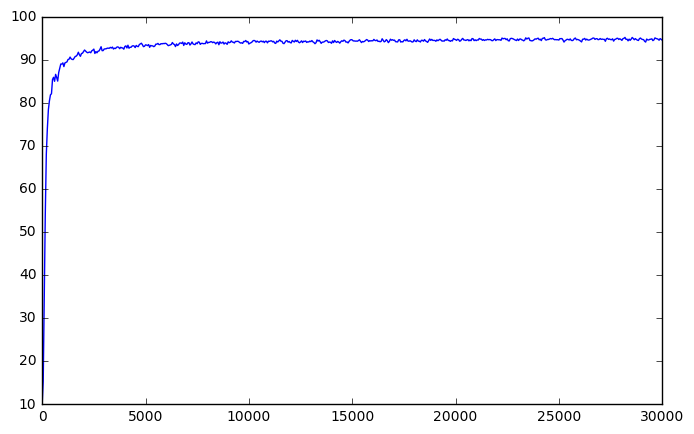

In [15]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.plot(50*np.arange(len(log['val_acc'])), log['val_acc'])

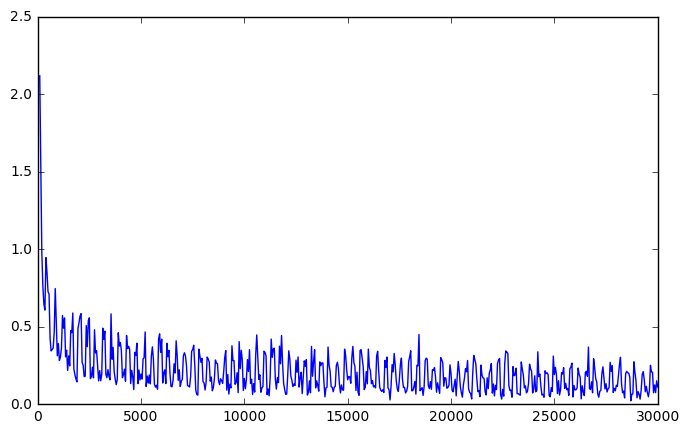

In [16]:
plt.plot(50*np.arange(len(log['train_loss']))[2:], log['train_loss'][2:])